In [ ]:
# TODO: Read: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2309.11798v4
# and https://www.nature.com/articles/s41598-024-58624-4 and https://www.nature.com/articles/s41598-024-58624-4
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.aimspress.com/aimspress-data/math/2024/2/PDF/math-09-02-178.pdf
# https://ieeexplore.ieee.org/abstract/document/7289461?casa_token=fHhNEidoqJMAAAAA:LM6FsCabVYqQ36U10oWBJSYUmAL4X1_yraUZv51GF3vsfDsp15CrrOFpI-o7PRtfX_JPd9Gog3AGcHQ

In [1]:
import config as cfg
from utils import *
import seaborn as sns

In [2]:
# Load data
all_viajes = pd.read_csv('/Users/caro/Desktop/thesis_project/mobility_data/VIAJES/all_viajes_month_0322.csv')
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson')
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson')  # Load your GeoJSON file into a GeoDataFrame
gdf = gdf.to_crs(epsg=4326)

# Filter data
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')]

In [3]:
work = filtered_df.loc[(filtered_df['actividad_destino'] == 'trabajo_estudio')] # only trips from home to work
short_trips = all_viajes.loc[(all_viajes['distancia']=='0.5-2')]
long_trips = all_viajes.loc[(all_viajes['distancia']=='10-50')]

In [4]:
var_of_interest = 'Renta neta media por hogar'

In [5]:
G, trip_counts = define_graph(filtered_df, remove_weak_edges=True)
G = update_node_sizes(G, income, var_of_interest)
positions = get_positions(gdf)
edge_colors, edge_widths = set_art(G, 0.6)
plotly_graph(G, positions, edge_colors, edge_widths, var_of_interest)

In [6]:
G2, trip_counts2 = define_graph(work)
G2 = update_node_sizes(G2, income, var_of_interest)
positions = get_positions(gdf)
edge_colors2, edge_widths2 = set_art(G2, 0.6)
plotly_graph(G2, positions, edge_colors2, edge_widths2, var_of_interest)

In [7]:
G3, trip_counts3 = define_graph(short_trips)
G3 = update_node_sizes(G3, income, var_of_interest)
positions = get_positions(gdf)
edge_colors3, edge_widths3 = set_art(G3, 0.6)
plotly_graph(G3, positions, edge_colors3, edge_widths3, var_of_interest)

In [8]:
G4, trip_counts4 = define_graph(long_trips)
G4 = update_node_sizes(G4, income, var_of_interest)
positions = get_positions(gdf)
edge_colors4, edge_widths4 = set_art(G4, 0.6)
plotly_graph(G4, positions, edge_colors4, edge_widths4, var_of_interest)

In [9]:
G5, trip_counts5 = define_graph(all_viajes)
G5 = update_node_sizes(G5, income, var_of_interest)
positions = get_positions(gdf)
edge_colors5, edge_widths5 = set_art(G5, 0.6)
plotly_graph(G5, positions, edge_colors5, edge_widths5, var_of_interest)

## General Statistics

In [6]:
G.size(weight="weight")

79.40116002129507

In [7]:
degree_df = pd.DataFrame(nx.degree(G, weight='weight'),columns=["ID", "degree"])
degree_df.sort_values("degree", ascending=False)

,ID,degree
0,2807901,10.400011
9,2807913,9.993135
12,2807915,9.308779
14,2807908,9.010620
11,2807905,8.625095
5,2807909,8.442461
7,2807911,8.344756
3,2807904,8.342711
19,2807920,8.115190
4,2807907,7.945866


In [8]:
len(G.edges)

143

In [9]:
nx.degree(G, weight='weight')

DiDegreeView({2807901: 10.400011207935218, 2807902: 7.895822242147441, 2807903: 6.727591134523243, 2807904: 8.342710639132505, 2807907: 7.945865672896412, 2807909: 8.442461262573904, 2807910: 7.53523494634201, 2807911: 8.344756087309815, 2807912: 6.546162683179691, 2807913: 9.993135139678891, 2807914: 6.67858443778195, 2807905: 8.625094566953404, 2807915: 9.308778615259605, 2807906: 6.243240214071562, 2807908: 9.010619518619182, 2807916: 7.584661940653984, 2807917: 5.629465661688476, 2807918: 5.6329681414441435, 2807919: 6.01832497408165, 2807920: 8.115189554204377, 2807921: 3.7816414021126956})

In [28]:
nx.average_clustering(G, weight='weight')

0.21230141366296199

In [10]:
nx.eigenvector_centrality(G, weight='weight')

{2807901: 0.36463413351161694,
 2807902: 0.18734766270482014,
 2807903: 0.2060166941174272,
 2807904: 0.31792350173492684,
 2807907: 0.33931888049419123,
 2807909: 0.3054252981503921,
 2807910: 0.16490107873232523,
 2807911: 0.1525803228992868,
 2807912: 0.10657336426526152,
 2807913: 0.14430551636295416,
 2807914: 0.15380854362726434,
 2807905: 0.31621033017792716,
 2807915: 0.23975564957848347,
 2807906: 0.22055409029103903,
 2807908: 0.283535259054367,
 2807916: 0.20010420318282074,
 2807917: 0.07045358942089425,
 2807918: 0.06714080793478541,
 2807919: 0.11119056080483006,
 2807920: 0.14593519910698316,
 2807921: 0.06331426850033595}

In [11]:
nx.betweenness_centrality(G, weight='weight')

{2807901: 0.17894736842105263,
 2807902: 0.031578947368421054,
 2807903: 0.02368421052631579,
 2807904: 0.09736842105263158,
 2807907: 0.018421052631578946,
 2807909: 0.02631578947368421,
 2807910: 0.03684210526315789,
 2807911: 0.10263157894736842,
 2807912: 0.0,
 2807913: 0.09473684210526316,
 2807914: 0.08157894736842106,
 2807905: 0.09210526315789473,
 2807915: 0.05789473684210526,
 2807906: 0.0,
 2807908: 0.12368421052631579,
 2807916: 0.04473684210526316,
 2807917: 0.02368421052631579,
 2807918: 0.0,
 2807919: 0.05526315789473684,
 2807920: 0.08947368421052632,
 2807921: 0.0}

In [12]:
nx.shortest_path(G, source=2807901, target=2807921, weight='weight')

[2807901, 2807911, 2807905, 2807916, 2807921]

In [13]:
print_node_degrees(G)

Node Degrees (In-degree, Out-degree, Total degree):
Node 2807901: In-degree = 13, Out-degree = 8, Total degree = 21
Node 2807902: In-degree = 7, Out-degree = 8, Total degree = 15
Node 2807903: In-degree = 7, Out-degree = 6, Total degree = 13
Node 2807904: In-degree = 10, Out-degree = 7, Total degree = 17
Node 2807907: In-degree = 9, Out-degree = 6, Total degree = 15
Node 2807909: In-degree = 8, Out-degree = 6, Total degree = 14
Node 2807910: In-degree = 5, Out-degree = 8, Total degree = 13
Node 2807911: In-degree = 6, Out-degree = 9, Total degree = 15
Node 2807912: In-degree = 5, Out-degree = 6, Total degree = 11
Node 2807913: In-degree = 8, Out-degree = 10, Total degree = 18
Node 2807914: In-degree = 7, Out-degree = 7, Total degree = 14
Node 2807905: In-degree = 9, Out-degree = 7, Total degree = 16
Node 2807915: In-degree = 7, Out-degree = 9, Total degree = 16
Node 2807906: In-degree = 5, Out-degree = 5, Total degree = 10
Node 2807908: In-degree = 7, Out-degree = 8, Total degree = 15


In [14]:
# Check total in-weights for each node
in_weights = check_in_weights(G)

Node 2807901 Total In-weight: 6.356272240746448
Node 2807902 Total In-weight: 3.9125220656224604
Node 2807903 Total In-weight: 3.6511530163355657
Node 2807904 Total In-weight: 4.956233012973185
Node 2807907 Total In-weight: 4.631791308246239
Node 2807909 Total In-weight: 4.602118299756228
Node 2807910 Total In-weight: 2.921376334444787
Node 2807911 Total In-weight: 3.550505758076718
Node 2807912 Total In-weight: 3.1613382274650452
Node 2807913 Total In-weight: 4.29384404158144
Node 2807914 Total In-weight: 3.2540278517190173
Node 2807905 Total In-weight: 4.8016755863151115
Node 2807915 Total In-weight: 4.034632519824036
Node 2807906 Total In-weight: 2.9615007425257085
Node 2807908 Total In-weight: 4.37314018324974
Node 2807916 Total In-weight: 3.7635966264114997
Node 2807917 Total In-weight: 2.7398918434251454
Node 2807918 Total In-weight: 2.6283448681666624
Node 2807919 Total In-weight: 3.2522065622460703
Node 2807920 Total In-weight: 3.6300260584493826
Node 2807921 Total In-weight: 1

In [15]:
# Check total out-weights for each node
out_weights = check_out_weights(G)

Node 2807901 Total Out-weight: 4.043738967188769
Node 2807902 Total Out-weight: 3.98330017652498
Node 2807903 Total Out-weight: 3.076438118187677
Node 2807904 Total Out-weight: 3.3864776261593206
Node 2807907 Total Out-weight: 3.314074364650173
Node 2807909 Total Out-weight: 3.840342962817675
Node 2807910 Total Out-weight: 4.613858611897223
Node 2807911 Total Out-weight: 4.794250329233097
Node 2807912 Total Out-weight: 3.384824455714646
Node 2807913 Total Out-weight: 5.6992910980974525
Node 2807914 Total Out-weight: 3.424556586062933
Node 2807905 Total Out-weight: 3.8234189806382917
Node 2807915 Total Out-weight: 5.274146095435569
Node 2807906 Total Out-weight: 3.2817394715458543
Node 2807908 Total Out-weight: 4.6374793353694415
Node 2807916 Total Out-weight: 3.8210653142424835
Node 2807917 Total Out-weight: 2.8895738182633304
Node 2807918 Total Out-weight: 3.0046232732774807
Node 2807919 Total Out-weight: 2.7661184118355795
Node 2807920 Total Out-weight: 4.485163495754994
Node 2807921

In [16]:
adj_matrix = get_adj_matrix(G)

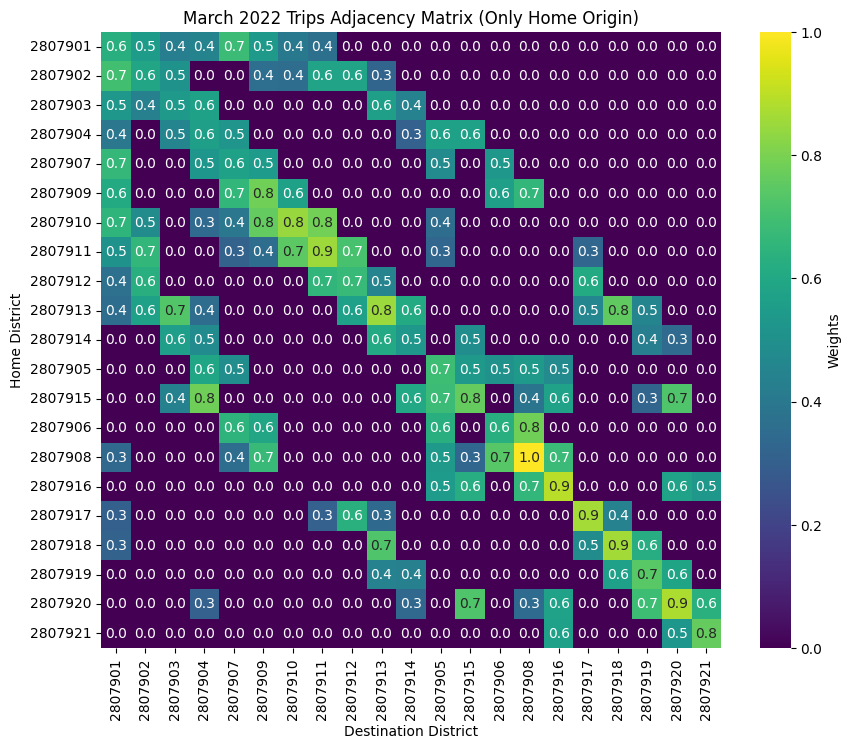

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    adj_matrix, 
    annot=True, 
    cmap='viridis', 
    cbar_kws={'label': 'Weights'}, 
    fmt=".1f"
)
plt.title('March 2022 Trips Adjacency Matrix (Only Home Origin)')
plt.xlabel('Destination District')
plt.ylabel('Home District');

In [76]:
# nx.write_gml(G, "0322_home_origin_graph.gml")

## Trip count analysis

In [19]:
high_rent_df = trip_counts[trip_counts['renta'] == '>15'].sort_values(by='trip_count', ascending=False)
high_rent_top3 = high_rent_df.head(3)
high_rent_bottom3 = high_rent_df.tail(3)

# Filter medium rent (10-15)
medium_rent_df = trip_counts[trip_counts['renta'] == '10-15'].sort_values(by='trip_count', ascending=False)
medium_rent_top3 = medium_rent_df.head(3)
medium_rent_bottom3 = medium_rent_df.tail(3)

# Filter low rent (<10)
low_rent_df = trip_counts[trip_counts['renta'] == '<10'].sort_values(by='trip_count', ascending=False)
low_rent_top3 = low_rent_df.head(3)
low_rent_bottom3 = low_rent_df.tail(3)

# Combine the results into one DataFrame for easy viewing
top3_bottom3_combined = pd.concat([
    high_rent_top3, high_rent_bottom3,
    medium_rent_top3, medium_rent_bottom3,
    low_rent_top3, low_rent_bottom3
])

In [20]:
top3_bottom3_combined

,origen,destino,renta,trip_count,weight
154,2807908,2807908,>15,36658,1.000000
330,2807916,2807916,>15,32866,0.893749
176,2807909,2807909,>15,28981,0.784892
312,2807915,2807919,>15,12507,0.323293
33,2807902,2807913,>15,12496,0.322985
76,2807904,2807914,>15,11910,0.306565
418,2807920,2807920,10-15,32256,0.876657
352,2807917,2807917,10-15,31835,0.864860
374,2807918,2807918,10-15,31698,0.861022
346,2807917,2807911,10-15,11947,0.307602


In [21]:
fig = plot_communities(G, positions, nx.community.louvain_communities(G, weight='weight', seed=1234), edge_colors, edge_widths, var_of_interest)

In [22]:
fig.show()

In [21]:
fig.write_html("madrid_districts_mobility.html")

In [15]:
plot_communities(G2, positions, nx.community.louvain_communities(G2), edge_colors, edge_widths, var_of_interest)

In [16]:
plot_communities(G3, positions, nx.community.louvain_communities(G3), edge_colors, edge_widths, var_of_interest)

In [17]:
plot_communities(G4, positions, nx.community.louvain_communities(G4), edge_colors, edge_widths, var_of_interest)

In [24]:
plot_communities(G5, positions, nx.community.louvain_communities(G5), edge_colors, edge_widths, var_of_interest)

In [18]:
plot_communities(G, nx.circular_layout(G), nx.community.louvain_communities(G, weight='weight', resolution=1.2, seed=1234), edge_colors, edge_widths, var_of_interest)

In [19]:
nx.community.modularity(G, nx.community.louvain_communities(G, weight='weight', seed=1234), weight='weight')

0.4167989713121699

## Testing Infomap

In [51]:
edges_with_weights = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]

df_edges = pd.DataFrame(edges_with_weights, columns=['source', 'target', 'weight'])
df_edges = df_edges[df_edges['weight'] >= 0.3] # NOTE: Infomap only finds 1 community if I leave edges as they are. Hence, I had to cut edges 

df_edges.to_csv('infomap_input.txt', sep=' ', header=False, index=False)

In [52]:
df_edges

,source,target,weight
0,2807901,2807901,0.629914
1,2807901,2807902,0.548320
2,2807901,2807903,0.424445
3,2807901,2807904,0.448233
6,2807901,2807907,0.680910
...,...,...,...
418,2807920,2807920,0.876657
419,2807920,2807921,0.633192
435,2807921,2807916,0.566085
439,2807921,2807920,0.526633


## Community Analysis

In [21]:
communities = nx.community.louvain_communities(G, weight='weight', seed=1234)

In [22]:
len(communities)

4

In [23]:
def average_degree_per_community(G, communities):
    community_avg_in_degrees = []
    community_avg_out_degrees = []
    
    for community in communities:
        in_degrees = [G.in_degree(node,  weight='weight') for node in community]  # Get in-degree for each node
        out_degrees = [G.out_degree(node,  weight='weight') for node in community] 
        avg_in_degree = sum(in_degrees) / len(community)        # Compute average in-degree
        avg_out_degree = sum(out_degrees) / len(community)
        community_avg_in_degrees.append(avg_in_degree)
        community_avg_out_degrees.append(avg_out_degree)
        print(f"Community {community} - Average In-degree: {avg_in_degree} - Average Out-degree: {avg_out_degree}")
    
    return community_avg_in_degrees, community_avg_out_degrees

# Calculate and display average in-degree for each community
average_degree_per_community(G, communities)

Community {2807917, 2807910, 2807911, 2807912, 2807901, 2807902} - Average In-degree: 3.7736510782967674 - Average Out-degree: 3.951591059803675
Community {2807905, 2807906, 2807907, 2807908, 2807909} - Average In-degree: 4.2740452240186055 - Average Out-degree: 3.779411023004287
Community {2807904, 2807913, 2807914, 2807903, 2807918, 2807919} - Average In-degree: 3.672634892170324 - Average Out-degree: 3.559584185603407
Community {2807920, 2807921, 2807915, 2807916} - Average In-degree: 3.3383045195998773 - Average Out-degree: 3.8592633584577882


([3.7736510782967674,
  4.2740452240186055,
  3.672634892170324,
  3.3383045195998773],
 [3.951591059803675, 3.779411023004287, 3.559584185603407, 3.8592633584577882])